# Setup colab

> **IMPORTANT**
> Nel caso si utilizzi google Colab c'è da caricare i file di input.

# Setup locale

In [1]:
# Path su linux
#path = './data/Dataset1_BankClients.xlsx'

# Path su windows - comando da inserire 
path =  "C:/Users/pa_ca/Documents/GitHub/Fintech_BC/BC1/data/Dataset1_BankClients.xlsx"

# Data Loading

In [2]:
import pandas as pd

# Load data in a DataFrame
data = pd.read_excel(path)

# Let's inspect the first 5 record
print(data.head())
# Drop the column by its actual name (e.g., 'ID' or the actual name of the column)
data = data.drop(columns=['ID'])  # Replace 'ID' with the actual column name to drop

   ID  Age  Gender  Job  Area  CitySize  FamilySize    Income    Wealth  \
0   1   24       1    1     2         2           4  0.668046  0.702786   
1   2   47       1    2     2         3           1  0.858453  0.915043   
2   3   38       0    2     1         2           2  0.926818  0.898316   
3   4   67       0    2     1         2           3  0.538797  0.423180   
4   5   33       0    2     1         3           1  0.806659  0.731404   

       Debt    FinEdu       ESG   Digital  BankFriend  LifeStyle    Luxury  \
0  0.262070  0.741853  0.483684  0.698625    0.618259   0.607877  0.897369   
1  0.730430  0.859423  0.537167  0.959025    0.785936   0.862271  0.913729   
2  0.441272  0.485953  0.649434  0.750265    0.699725   0.755404  0.765199   
3  0.600401  0.493144  0.533829  0.590165    0.675353   0.334432  0.517209   
4  0.831449  0.856286  0.784940  0.710026    0.758793   0.908878  0.611610   

     Saving  Investments  
0  0.283222            1  
1  0.821590            3  

pip # Data Preparation  

In [3]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import numpy as np

# Specify categorical variables
categorical_columns = ['Gender', 'Job', 'Area', 'CitySize', 'Investments']

# Split variables
numerical_features = data.drop(columns=categorical_columns)  # Exclude categorical variables
categorical_features = data[categorical_columns]  # Select categorical variables

# Convert categorical in typ 'category' (for OneHotEncoder)
categorical_features = categorical_features.astype('category')

# Normalize numerical variables
scaler = MinMaxScaler()
X_num = scaler.fit_transform(numerical_features)

# One-hot encoding categorical variables
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')  # Dummy encoding - set 1 feature to all 0s - ignoring unknwown values
X_cat = encoder.fit_transform(categorical_features).toarray()  # Convert into a dense matrix

# Concatenation of numerical and categorical variables
X = np.hstack((X_num, X_cat))

# Summary of the dataset
print("Numerical Features Shape:", X_num.shape)
print("Categorical Features Shape:", X_cat.shape)
print("Combined Features Shape:", X.shape)


Numerical Features Shape: (5000, 12)
Categorical Features Shape: (5000, 11)
Combined Features Shape: (5000, 23)


# Data Exploration 

Firstly, control covariances of numerical features between features and target variable. We can see that the most correlated features have a correlation of 0.05

Covariance Matrix Shape: (12, 12)


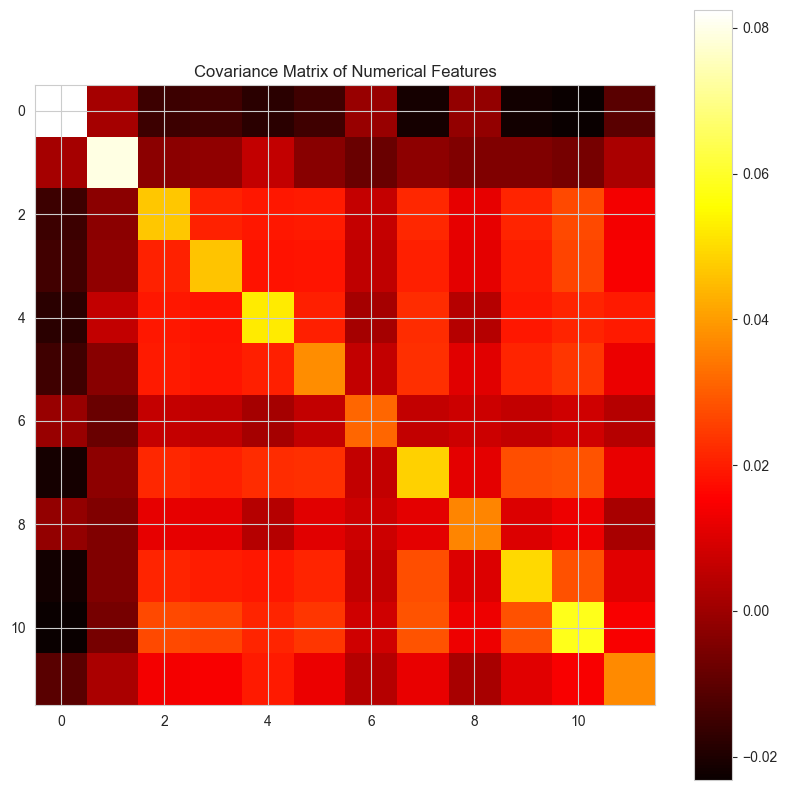

In [16]:
import matplotlib.pyplot as plt

# Covariance matrix of numerical features
cov_matrix = np.cov(X_num.T)
print("Covariance Matrix Shape:", cov_matrix.shape) 

# Plot the covariance matrix
plt.figure(figsize=(10, 10))
plt.imshow(cov_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Covariance Matrix of Numerical Features')
plt.show()

# Clustering 

(array([1607.,    0.,    0.,    0., 1203.,    0.,    0.,    0.,  996.,
           0.,    0.,    0.,    0.,  726.,    0.,    0.,    0.,  271.,
           0.,    0.,    0.,  197.]),
 array([0.        , 0.04545455, 0.09090909, 0.13636364, 0.18181818,
        0.22727273, 0.27272727, 0.31818182, 0.36363636, 0.40909091,
        0.45454545, 0.5       , 0.54545455, 0.59090909, 0.63636364,
        0.68181818, 0.72727273, 0.77272727, 0.81818182, 0.86363636,
        0.90909091, 0.95454545, 1.        ]),
 <BarContainer object of 22 artists>)

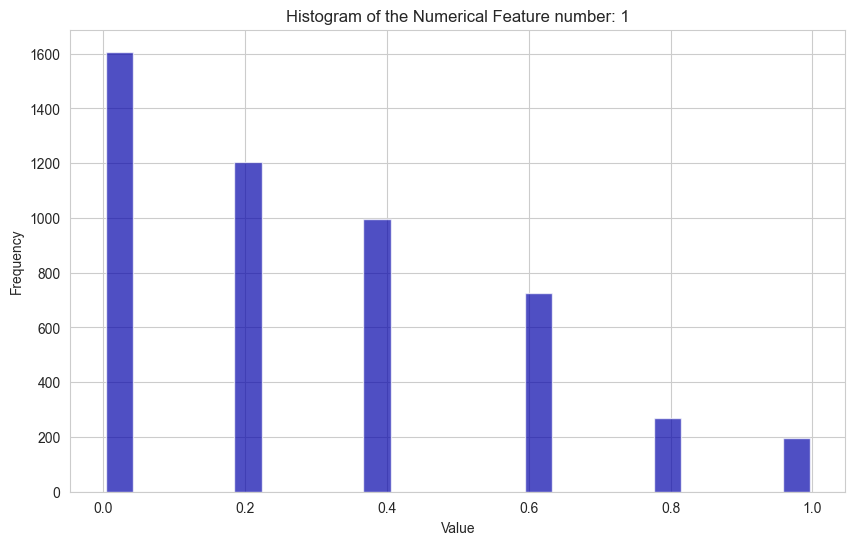

In [17]:
import matplotlib.pyplot as plt

# Histogram of the first numerical feature
plt.figure(figsize=(10, 6))
feature_n = 1
plt.title(f'Histogram of the Numerical Feature number: {feature_n}')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.hist(x=X_num[:, feature_n], bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)



In [ ]:
from sklearn.manifold import MDS
import gower

print('Original Dimension of X = ', X.shape)
# Create an MDS model with the desired number of dimensions
# Number of dimensions for visualization
n_components = 3  
mds = MDS(n_components=n_components, verbose = 1, dissimilarity='precomputed')

# Calcolare matrice delle distanze usando la distanza gower
gower_distances = gower.gower_matrix(X)
print('Dimension of gower_distances = ',gower_distances.shape)

# Fit the MDS model to your data
X_reduced = mds.fit_transform(gower_distances)

print('Dimension of X after MDS = ',X_reduced.shape)

Original Dimension of X =  (5000, 23)
Dimension of gower_distances =  (5000, 5000)
breaking at iteration 190 with stress 38388.86997716151


In [ ]:
# Enable interactive backend
#%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Create the interactive 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create the scatter plot
scatter = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], 
                    c='skyblue', edgecolor='darkblue', alpha=0.8)

# Add labels and title
ax.set_xlabel('First Component')
ax.set_ylabel('Second Component')
ax.set_zlabel('Third Component')
ax.set_title('MDS of the Gower distance matrix')

# Enable rotation and zoom with mouse
plt.tight_layout()
plt.show()

In [6]:
from sklearn.manifold import MDS
import gower

print('Original Dimesnion of X = ', X.shape)
# Create an MDS model with the desired number of dimensions
# Number of dimensions for visualization
n_components = 2 
mds = MDS(n_components=n_components, verbose = 1, dissimilarity='precomputed')

# Calcolare matrice delle distanze usando la distanza gower
gower_distances = gower.gower_matrix(X)
print('Dimension of gower_distances = ',gower_distances.shape)

# Fit the MDS model to your data
X_reduced = mds.fit_transform(gower_distances)

print('Dimension of X after MDS = ',X_reduced.shape)

Original Dimesnion of X =  (5000, 23)
Dimension of gower_distances =  (5000, 5000)
breaking at iteration 275 with stress 83772.11879916844
Dimension of X after MDS =  (5000, 2)


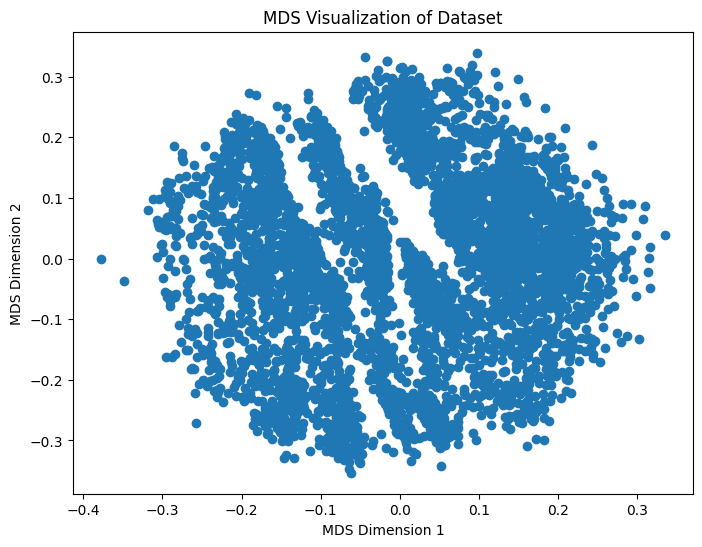

In [7]:
# Visualize the reduced data
plt.figure(figsize=(8, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1])
plt.title("MDS Visualization of Dataset")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.show()

Come funziona il Multi-Dimensional Scaling? [MDS](https://en.wikipedia.org/wiki/Multidimensional_scaling)

Alla buona: tipo PCA ma sulle coordinate cartesiane che scegli tu a che punto arrivare.



Optimal number of clusters: 5


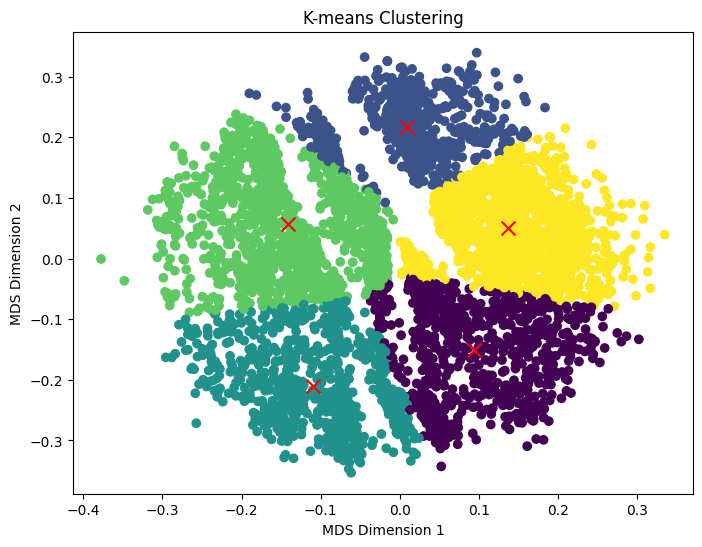

In [8]:
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids

# Function to optimize the number of clusters
def optimal_number_of_clusters(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2

# Optimize the number of clusters
wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, init='k-means++')
    kmeans.fit(X_reduced)
    wcss.append(kmeans.inertia_)

n = optimal_number_of_clusters(wcss)
print("Optimal number of clusters:", n)

# Create a KMeans model
kmeans = KMeans(n_clusters=n, init='k-means++')

# Fit the model to the data
kmeans.fit(X_reduced)

# Get the cluster centroids
centroids = kmeans.cluster_centers_

# Get the cluster labels
labels = kmeans.labels_

# Visualize the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, c='r')
plt.title("K-means Clustering")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.show()
